In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mthree

# Importing standard Qiskit libraries - Updated for Qiskit 1.x
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister

from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.coupling import CouplingMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import QFT, RealAmplitudes
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import *
from qiskit.converters.circuit_to_dag import circuit_to_dag

# Updated IBMQ import
from qiskit_ibm_provider import IBMProvider
# Remove deprecated IBMQ.load_account() and update authentication
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-research-2', group='columbia-uni-1', project='main')

backend = AerSimulator()

/Users/manuelpaez/Documents/GitHub/quantum_pattern_algorithm/quantum-env/lib/python3.13/site-packages/qiskit_ibm_provider/api/session.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/var/folders/sp/9wqhm0l5547gnb71gx_8698c0000gn/T/ipykernel_38232/848359214.py:23: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [2]:
%run utils.py 

In [3]:
class bin_tree:
    size = None
    values = None

    def __init__(self, values):
        self.size = len(values)
        self.values = values

    def parent(self, key):
        return int((key-0.5)/2)

    def left(self, key):
        return int(2 * key + 1)

    def right(self, key):
        return int(2 * key + 2)

    def root(self):
        return 0

    def __getitem__(self, key):
        return self.values[key]
    
class Encoding:
    qcircuit = None
    quantum_data = None
    classical_data = None
    num_qubits = None
    tree = None
    output_qubits = []

    def __init__(self, input_vector, encode_type='amplitude_encoding'):
        if encode_type == 'amplitude_encoding':
            self.amplitude_encoding(input_vector)
        if encode_type == 'qubit_encoding':
            self.qubit_encoding(input_vector)
        if encode_type == 'dc_amplitude_encoding':
            self.dc_amplitude_encoding(input_vector)
        if encode_type == 'basis_encoding':
            self.basis_encoding(input_vector)
    
    def basis_encoding(self, input_vector, n_classical=1):
        """
        encoding a binary string x in a basis state |x>
        """
        self.num_qubits = int(len(input_vector))
        self.quantum_data = qiskit.QuantumRegister(self.num_qubits)
        self.classical_data = qiskit.ClassicalRegister(n_classical)
        self.qcircuit = qiskit.QuantumCircuit(self.quantum_data, self.classical_data)
        for k, _ in enumerate(input_vector):
            if input_vector[k] == 1:
                self.qcircuit.x(self.quantum_data[k])


    def qubit_encoding(self, input_vector, n_classical=1):
        """
        encoding a binary string x as
        """
        input_pattern = qiskit.QuantumRegister(len(input_vector))
        classical_register = qiskit.ClassicalRegister(n_classical)
        self.qcircuit = qiskit.QuantumCircuit(input_pattern, classical_register)
        for k, _ in enumerate(input_vector):
            self.qcircuit.ry(input_vector[k], input_pattern[k])
            
    @staticmethod
    def _recursive_compute_beta(input_vector, betas):
        if len(input_vector) > 1:
            new_x = []
            beta = []
            for k in range(0, len(input_vector), 2):
                norm = np.sqrt(input_vector[k] ** 2 + input_vector[k + 1] ** 2)
                new_x.append(norm)
                if norm == 0:
                    beta.append(0)
                else:
                    if input_vector[k] < 0:
                        beta.append(2 * np.pi - 2 * np.arcsin(input_vector[k + 1] / norm)) ## testing
                    else:
                        beta.append(2 * np.arcsin(input_vector[k + 1] / norm))
            Encoding._recursive_compute_beta(new_x, betas)
            betas.append(beta)
            output = []
    
    @staticmethod
    def _index(k, circuit, control_qubits, numberof_controls):
        binary_index = '{:0{}b}'.format(k, numberof_controls)
        for j, qbit in enumerate(control_qubits):
            if binary_index[j] == '1':
                circuit.x(qbit)


    def amplitude_encoding(self, input_vector):
        """
        load real vector x to the amplitude of a quantum state
        """
        self.num_qubits = int(np.log2(len(input_vector)))
        self.quantum_data = qiskit.QuantumRegister(self.num_qubits)
        self.qcircuit = qiskit.QuantumCircuit(self.quantum_data)
        newx = np.copy(input_vector)
        betas = []
        Encoding._recursive_compute_beta(newx, betas)
        self._generate_circuit(betas, self.qcircuit, self.quantum_data)
        
    def dc_amplitude_encoding(self, input_vector):
        self.num_qubits = int(len(input_vector))-1
        self.quantum_data = qiskit.QuantumRegister(self.num_qubits)
        self.qcircuit = qiskit.QuantumCircuit(self.quantum_data)
        newx = np.copy(input_vector)
        betas = []
        Encoding._recursive_compute_beta(newx, betas)
        self._dc_generate_circuit(betas, self.qcircuit, self.quantum_data)

    def _dc_generate_circuit(self, betas, qcircuit, quantum_input):

        k = 0
        linear_angles = []
        for angles in betas:
            linear_angles = linear_angles + angles
            for angle in angles:
                qcircuit.ry(angle, quantum_input[k])
                k += 1

        self.tree = bin_tree(quantum_input)
        my_tree = self.tree

        last = my_tree.size - 1
        actual = my_tree.parent(last)
        level = my_tree.parent(last)
        while actual >= 0:
            left_index = my_tree.left(actual)
            right_index = my_tree.right(actual)
            while right_index <= last:

                qcircuit.cswap(my_tree[actual], my_tree[left_index], my_tree[right_index])

                left_index = my_tree.left(left_index)
                right_index = my_tree.left(right_index)
            actual -= 1
            if level != my_tree.parent(actual):
                level -= 1

        # set output qubits
        next_index = 0
        while next_index < my_tree.size:
            self.output_qubits.append(next_index)
            next_index = my_tree.left(next_index)

    def _generate_circuit(self, betas, qcircuit, quantum_input):
        numberof_controls = 0  # number of controls
        control_bits = []
        for angles in betas:
            if numberof_controls == 0:
                qcircuit.ry(angles[0], quantum_input[self.num_qubits-1])
                numberof_controls += 1
                control_bits.append(quantum_input[self.num_qubits-1])
            else:
                for k, angle in enumerate(reversed(angles)):
                    Encoding._index(k, qcircuit, control_bits, numberof_controls)

                    qcircuit.mcry(angle,
                                  control_bits,
                                  quantum_input[self.num_qubits - 1 - numberof_controls],
                                  None,
                                  mode='noancilla')

                    Encoding._index(k, qcircuit, control_bits, numberof_controls)
                control_bits.append(quantum_input[self.num_qubits - 1 - numberof_controls])
                numberof_controls += 1

Circuit: 0 # CX gates:  1
1-error of circ 0: 0.9900
Circuit: 0 ACCEPTED - # CX gates:  1
1-error of circ 0: 0.9900
Circuit: 1 # CX gates:  1
1-error of circ 1: 0.9900
Circuit: 1 ACCEPTED - # CX gates:  1
1-error of circ 1: 0.9900
Circuit: 2 # CX gates:  1
1-error of circ 2: 0.9900
Circuit: 2 ACCEPTED - # CX gates:  1
1-error of circ 2: 0.9900
Circuit: 3 # CX gates:  1
1-error of circ 3: 0.9900
Circuit: 3 ACCEPTED - # CX gates:  1
1-error of circ 3: 0.9900
Circuit: 4 # CX gates:  1
1-error of circ 4: 0.9900
Circuit: 4 ACCEPTED - # CX gates:  1
1-error of circ 4: 0.9900
Circuit: 5 # CX gates:  1
1-error of circ 5: 0.9900
Circuit: 5 ACCEPTED - # CX gates:  1
1-error of circ 5: 0.9900
Circuit: 6 # CX gates:  1
1-error of circ 6: 0.9900
Circuit: 6 ACCEPTED - # CX gates:  1
1-error of circ 6: 0.9900
Circuit: 7 # CX gates:  1
1-error of circ 7: 0.9900
Circuit: 7 ACCEPTED - # CX gates:  1
1-error of circ 7: 0.9900
Circuit: 8 # CX gates:  1
1-error of circ 8: 0.9900
Circuit: 8 ACCEPTED - # CX g

/var/folders/sp/9wqhm0l5547gnb71gx_8698c0000gn/T/ipykernel_38232/2869148172.py:125: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/var/folders/sp/9wqhm0l5547gnb71gx_8698c0000gn/T/ipykernel_38232/2869148172.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


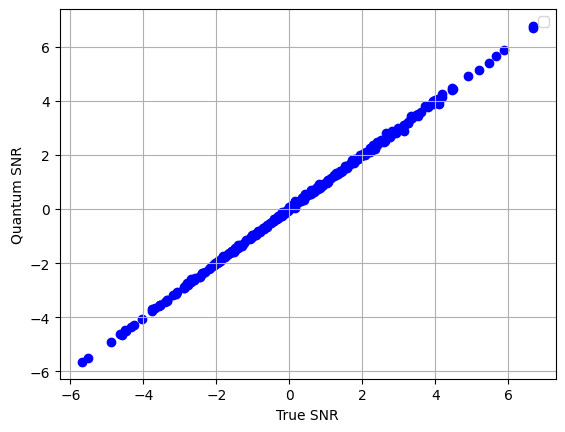

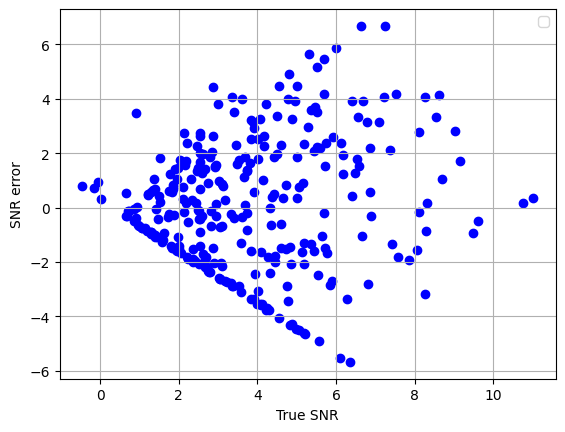

In [4]:
def sub_circ(w_: np.ndarray, h_: np.ndarray):   
    qr = QuantumRegister(4)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, cr)
    
    #data
    betas_d = []
    angles_d = []
    Encoding._recursive_compute_beta(w_, betas_d) 
    for alist in betas_d:
        angles_d += alist

    #signal
    betas_s = []
    angles_s = []
    Encoding._recursive_compute_beta(h_, betas_s) 
    for alist in betas_s:
        angles_s += alist  
    
    #add r circuits
    for k, val in enumerate(angles_d):
        qc.ry(val, k)

    for k, val in enumerate(angles_s): 
        qc.ry(val, k+3)
    
    qc.cx(1,2)
    qc.ccx(0,2,1)
    qc.measure([0,1,3], [0,1,2])  
    
    return qc

# classical_snr = []
# quantum_snr = []
# for k in range(0, 2):
h_features1 = np.array([2, -1])
signalshift = -min(h_features1) + 0.1 
h_features = (h_features1 + signalshift) ** 0.5  
h_features = h_features / np.linalg.norm(h_features)

#data
dd = np.zeros((100, 4))
datashift = np.zeros((100, 4))
data = np.zeros((100, 4))
    
for i in range(0, 100):
    dd[i] = np.random.normal(0, 1, 4)
    datashift[i] = -min(dd[i]) + 0.1
    data[i] = (dd[i] + datashift[i]) ** 0.5 #don't normalize yet   

    
circuit_lists = []
for i in range(0, 100): 
        
    #break data into parts
    w_features = data[i]
    w_features = w_features / np.linalg.norm(w_features)
        
    #get subcircuit
    qc_sub = sub_circ(w_features, h_features)
        
    #To create correct circuit - Updated for AerSimulator compatibility
    while True: 
        trans_circ = transpile(qc_sub, backend=backend, optimization_level=3)
        initial_layout = trans_circ
        one_minus_error = 1
        
        # Updated error calculation for AerSimulator (no properties available)
        # Use estimated error rate for CX gates instead of backend.properties()
        cx_count = trans_circ.count_ops().get('cx', 0)
        estimated_cx_error = 0.01  # Assume 1% error rate per CX gate
        one_minus_error = (1 - estimated_cx_error) ** cx_count
        
        print('Circuit: '+str(i) + ' # CX gates: ', cx_count)
        print('1-error of circ '+str(i)+': {:.4f}'.format(one_minus_error))
        
        if (cx_count <= 7 and one_minus_error > 0.92):
            print('Circuit: '+str(i)+' ACCEPTED - # CX gates: ', cx_count)
            print('1-error of circ '+str(i)+': {:.4f}'.format(one_minus_error))
            break
            
    circuit_lists.append(trans_circ)

    
# Updated to use backend.run() instead of deprecated execute()
job = backend.run(circuit_lists, shots=20000)
results = job.result()
countsa = results.get_counts() 
# print(countsa)
table =['000','110','010','101','001','111']
# table =['000', '001', '010', '011', '100', '101','110','111']
    
q4 = np.zeros((100,3))
cl4 = np.zeros((100,3))
qp4 = np.zeros((100,3))
clp4 = np.zeros((100,3))
corr = np.zeros((100,3))
    
for j in range(0, 100): 
    counts = countsa[j] 
    
    for i in range(0, 3):  
        w_features = data[j][i:i+2]
        w_features = w_features / np.linalg.norm(w_features)
        
        w_features1 = data[j][i:i+2] ** 2 - datashift[j][0]
        
        
        # w_features = w_features / np.linalg.norm(w_features)
        # w_features1 = data[i:i+2]**2-datashift
        qp4[j][i]=((counts.get(table[2*i], 0)+counts.get(table[2*i+1], 0))/(20000))
        clp4[j][i]=(np.dot(dd[j][i:i+2], h_features1) + np.sum(datashift[j][0]*h_features1 + signalshift*w_features1 + datashift[j][0]*signalshift)) / (np.linalg.norm((h_features1+signalshift)**0.5)**2*np.linalg.norm(data[j])**2)
        q4[j][i]= ((counts.get(table[2*i], 0)+counts.get(table[2*i+1], 0))/(20000)) * np.linalg.norm((h_features1+signalshift)**0.5)**2 * np.linalg.norm(data[j])**2 - np.sum(datashift[j][0]*h_features1+signalshift*w_features1+datashift[j][0]*signalshift)
        cl4[j][i]=(np.dot(dd[j][i:i+2], h_features1))
        corr[j][i]= (np.sum(datashift[j][0]*h_features1 + signalshift*w_features1 + datashift[j][0]*signalshift))

# print(qp4)
# print(clp4)


plt.figure()
plt.scatter(cl4, q4, color="blue") 
plt.xlabel('True SNR')
plt.ylabel('Quantum SNR')
plt.legend()
plt.grid()

plt.figure()
plt.scatter(corr, cl4, color="blue") 
plt.xlabel('True SNR')
plt.ylabel('SNR error')
plt.legend()
plt.grid()